<a href="https://colab.research.google.com/github/Dan-Burns/Seq2Ensemble/blob/least_squares/ColabOpenAWSEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup the software

In [1]:
#@title Run this cell to set everything up. This can take several minutes.
import warnings
warnings.filterwarnings("ignore")
!pip install -q condacolab
import condacolab
condacolab.install() 
!git clone https://github.com/Dan-Burns/molecular_dynamics_analysis_tools.git &> /dev/null


#1. Install OpenMM and core dependencies
#!conda install -c conda-forge openmm pdbfixer mdtraj biopython py3dmol numpy pandas matplotlib
print("Installing Python packages.")
!conda env update --file molecular_dynamics_analysis_tools/seq_to_ensemble_environment.yml --prune &> /dev/null
#2. Download openawsem
print("Installing OpenAwsem")
!git clone https://github.com/PotoyanGroup/openawsem &> /dev/null

#3. Download pdb_seqres
!wget ftp://ftp.wwpdb.org/pub/pdb/derived_data/pdb_seqres.txt &> /dev/null
!mv pdb_seqres.txt openawsem/ &> /dev/null

#4. Download and isntall stride
!wget http://webclu.bio.wzw.tum.de/stride/stride.tar.gz &> /dev/null
!mkdir stride_loc && tar -xf stride.tar.gz -C ./stride_loc &> /dev/null
!cd stride_loc && make &> /dev/null
print('Done')

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:16
🔁 Restarting kernel...
Installing Python packages.
Installing OpenAwsem
Done


### Create Project and Run simulation

Upload a PDB file of protein which can be obtained either via AlphaFold or from PDB database. 

In [1]:
#@title Upload a PDB file
from google.colab import files
import os

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  os.rename(fn, 'input.pdb')

# Create project 

Saving eicfull_b4a89_unrelaxed_rank_4_model_1.pdb to eicfull_b4a89_unrelaxed_rank_4_model_1.pdb
User uploaded file "eicfull_b4a89_unrelaxed_rank_4_model_1.pdb" with length 720171 bytes


In [2]:
#@title Run a Molecular Dynamics with the [AWSEM](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008308) Coarse-Grained Force-Field for Proteins 
Temperature = 250.0 #@param {type:"number"}
Timesteps   = 10000 #@param {type:"number"}

!export OPENAWSEM_LOCATION=/content/openawsem/ && PATH={$PATH}:/content/stride_loc && python3 /content/openawsem/mm_create_project.py input.pdb
!cp input-openmmawsem.pdb template.pdb
!export OPENAWSEM_LOCATION=/content/openawsem/ && python3 ./openawsem/helperFunctions/convertOpenmmTrajectoryToStandardMovie.py template.pdb
# can we only report on every 10,000 frames.. or add status bar?
!export OPENAWSEM_LOCATION=/content/openawsem/ && python3 mm_run.py input  --steps $Timesteps --tempStart $Temperature --tempEnd $Temperature -f forces_setup.py 

#@markdown ---
#@markdown > Lu, Wei, et al. "OpenAWSEM with Open3SPN2: A fast, flexible, and accessible framework for large-scale coarse-grained biomolecular simulations." <em>PLoS computational biology 17.2 (2021): e1008308 </em>

input
[<Chain 0>, <Chain 1>]
Chains: BC
Chains info read from crystal_structure.pdb, chains to simulate:  BC
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 18024
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 18024
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 18024
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 18024
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 18024
  warnings.warn(
protein: input, length: 1146
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning

In [3]:
#@title Install Analysis Tools
%%capture
# should probably send all the shell commands to /dev/null so the user
# can get updated on what's going on with print statements.
!pip install MDAnalysis
!git clone https://github.com/Dan-Burns/molecular_dynamics_analysis_tools.git
!pip install paramagpy # not using atm
!pip install biopandas
!pip install scipy
!pip install parmed
from molecular_dynamics_analysis_tools.rdcs import *
from molecular_dynamics_analysis_tools.rdcs_least_squares import *
from molecular_dynamics_analysis_tools.useful_functions import identical_subunits
#### for rebuilding sidechains from CG structures
#https://download.igb.uci.edu/sidepro_readme.txt
# this is the main delay on this install cell
!wget https://download.igb.uci.edu/sidepro.linux.tar.gz
!tar xvf sidepro.linux.tar.gz
!conda install -c conda-forge pdbfixer
####
# might need this because using wget can throw an error randomly
import locale
locale.getpreferredencoding = lambda: "UTF-8"
###

import py3Dmol
from sklearn.decomposition import PCA
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
print('Done')

In [5]:
## Silence errors/warnings
#%%capture

#@title ##Perform RMSD Clustering of the Trajectory to Generate Conformational Ensembles
from Bio.PDB import PDBParser
import MDAnalysis.analysis.encore as encore
import MDAnalysis as mda
from MDAnalysis.analysis import align

#@markdown Set Maximum Number of Clusters to Generate.
#@markdown This will produce n ensembles composed of 1 to n structures.
#@markdown Subsequent RDC fitting will reveal the best ensemble among these.
n_clusters = 5 #@param {type:"number"}
import warnings
warnings.filterwarnings("ignore")
pdb   = 'template.pdb'
model = PDBParser().get_structure('structure',pdb) 

# hold chain IDs and residue object lists
# use to compare the subunits and figure out if they're identical or not
chains = {chain.id: chain.get_unpacked_list() for chain in model.get_chains()}

trajectory = 'movie.dcd'
structure = 'template.pdb'
u = mda.Universe(structure, trajectory)

#############################
# if it's a homo-multimer, separate the subunits and concatenate into
# a long single-subunit trajectory for clustering
# Otherwise deal with the trajectory and one or more subunits in its original form
if identical_subunits(chains) == True: 
  # make a dictionary of chain/subunit keys with atom selection values
  selections = {}
  for chain in chains.keys():
    selections[chain] = u.select_atoms('segid '+chain)

  # make a directory to hold the seperated subunits
  out_dir = 'seperated_trajectories/'
  if not os.path.exists(out_dir):
      os.makedirs(out_dir)
  # clean the directory if it already exists
  for f in os.listdir(out_dir):
      os.remove(out_dir+f)

  # Instead of writing the seperated trajectories to files, 
  # can probably use u.merge() - but people might want to download trajectories...
  for chain, selection in selections.items():
      with mda.Writer(f'{out_dir}chain_{chain}.dcd', selection.n_atoms) as W:
          for ts in u.trajectory:
              W.write(selection)
  # write one subunit to a pdb
  # can probably just use the selection instead of a saved pdb
  # assuming we're just working with EI dimer for this
  selections[list(selections.keys())[0]].write('one_subunit.pdb')
 
  # align the seperated subunit trajectory
  # conatenate
  seperated_trajs = [out_dir+traj for traj in os.listdir(out_dir) if traj.endswith('dcd')]
  pdb = 'one_subunit.pdb'
  ref = mda.Universe(pdb)
  sep_u = mda.Universe(pdb, seperated_trajs)
  aligned_traj_name = 'aligned_seperated_subunits.dcd'
  print('Aligning trajectory.')
  align.AlignTraj(sep_u, ref,select='name CA',filename=aligned_traj_name).run()


else: ## just align the original trajectory for clustering 
  from MDAnalysis.analysis import align
  print('Aligning trajectory.')
  aligned_traj_name = 'aligned_traj.dcd'
  ref = mda.Universe(pdb)
  align.AlignTraj(u, ref, select='name CA',filename=aligned_traj_name).run()

for cluster_iteration in range(n_clusters):
    print(f"Cluster iteration {cluster_iteration+1}")
    structure = pdb
    trajectory = aligned_traj_name
    u = mda.Universe(structure, trajectory)
    # add n_jobs argument so that all n_init are run in parallel (default is 10)
    ensemble = encore.cluster(u, method=encore.clustering.ClusteringMethod.KMeans(n_clusters=cluster_iteration+1))
    #####################################
    # change this selection from 'name CA' to 'protein' when using structure file with 
    # correct residue names
    #####################################
    selection = u.select_atoms('protein')
    ######################################
    clusters = []
    for i, cluster in enumerate(ensemble.clusters):
        u.trajectory[cluster.centroid]
        if not os.path.exists(f'cluster_{cluster_iteration+1}/'):
          os.makedirs(f'cluster_{cluster_iteration+1}/')
        selection.write(f'cluster_{cluster_iteration+1}/centroid_{i+1}.pdb')
        clusters.append(int(cluster.centroid))

print('Done')

Aligning trajectory.
Cluster iteration 1
Cluster iteration 2
Cluster iteration 3
Cluster iteration 4
Cluster iteration 5
Done


Saving RDC_obs to RDC_obs
User uploaded file "RDC_obs" with length 1277 bytes
Performing fit on ensemble 1
Performing fit on ensemble 2
Performing fit on ensemble 3
Performing fit on ensemble 4
Performing fit on ensemble 5


ValueError: ignored

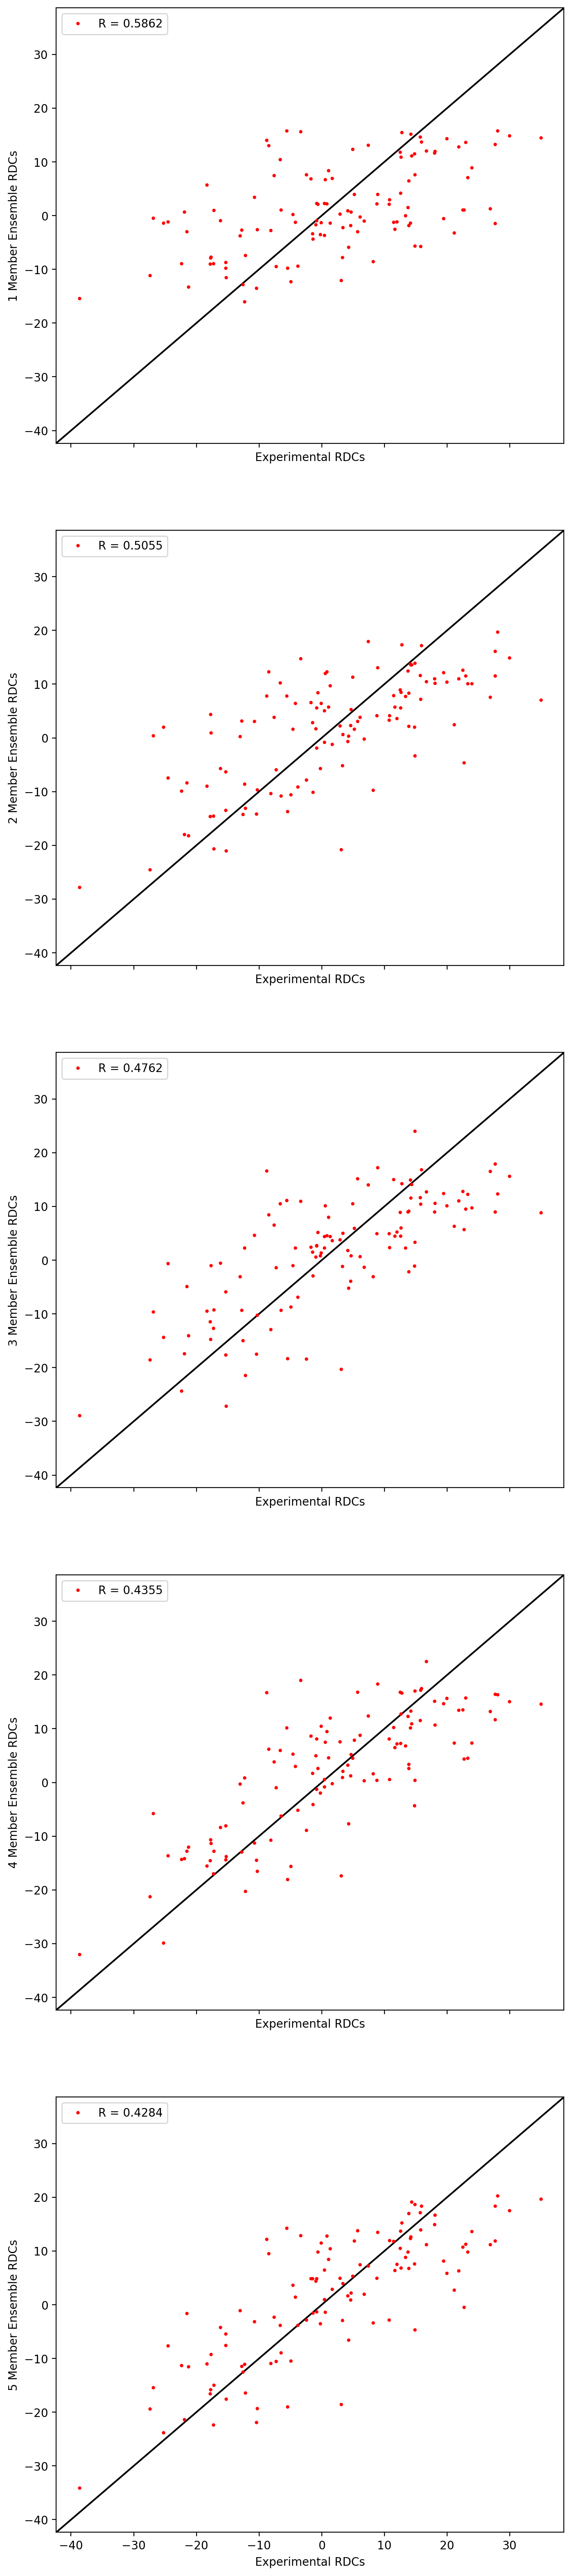

In [30]:
#@title Least Squares Fitting of RDCs to Ensembles

%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

uploaded_rdcs = files.upload()

for fn in uploaded_rdcs.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_rdcs[fn])))
  os.rename(fn, 'rdcs.dat')
#@markdown Upload your RDC file

rdc_file = 'rdcs.dat'

rdc_results = 'rdc_fitting_results'
if os.path.exists(rdc_results):
  pass
else:
  os.makedirs(rdc_results)


# make a list of the folders that contain the cluster iteration centroids
# will have to change the list comprehension if we add option to do specific cluster iterations
cluster_folders = [f'cluster_{i+1}' for i in range(n_clusters)]
fig, axs = plt.subplots(n_clusters,1,
                        sharex=True,sharey=True,
                        figsize=(8,n_clusters*8))
# save the backcalculated RDCs and R values
rdc_dictionary = {}
rdc_R_values = {}
final_pars = {}
for i, pdb_folder in enumerate(cluster_folders):
  print(f'Performing fit on ensemble {i+1}')
  fit = FitRDCs(pdb_folder,rdc_file)
  fit.fit_rdcs()

  # save back calculated rdcs and R
  rdc_dictionary[f'{i+1}_member_ensemble'] = fit.fitted_rdcs
  rdc_R_values[f'{i+1}_member_ensemble'] = round(fit.Rfactor,4)
  #parameters
  if i == 0:
    params = pd.DataFrame(fit.jac.x[np.newaxis,:],columns=['angle_a(rad)','angle_b(rad)','angle_c(rad)','Azz','r'],
               index=[f'centroid_{i+1}'])
    params.to_csv(f'{rdc_results}/{i+1}_member_ensemble_params.csv')
  else:
    params = pd.DataFrame(fit.jac.x.reshape(-1,5),
               columns=['angle_a(rad)','angle_b(rad)','angle_c(rad)','Azz','r'],
               index=[f'centroid_{j+1}' for j in range(i+1)])
    params.to_csv(f'{rdc_results}/{i+1}_member_ensemble_params.csv')

  # plot
  axs.flat[i].plot(fit.rdc_values, fit.fitted_rdcs, marker='o', lw=0, ms=2, c='r',
          label=f'R = {round(fit.Rfactor,4)}')

  # plot the diagonal
  l, h = axs.flat[i].get_xlim()
  axs.flat[i].plot([l,h],[l,h],'-k', zorder=0, ms=2)
  axs.flat[i].set_xlim(l,h)
  axs.flat[i].set_ylim(l,h)

  # labels
  axs.flat[i].set_xlabel("Experimental RDCs")
  axs.flat[i].set_ylabel(f"{i+1} Member Ensemble RDCs")
  axs.flat[i].legend()
fig.savefig(f'{rdc_results}/rdc_plots.pdf')

rdc_df = pd.DataFrame(rdc_dictionary,index=fit.residue_ids)
rdc_df.to_csv(f'{rdc_results}/ensemble_rdcs.csv')
rdc_R_df = pd.DataFrame(rdc_R_values,index=['R'])
rdc_R_df.to_csv(f'{rdc_results}/ensemble_R_values.csv')

print('Done')

In [35]:
#@title Zip and Download the Results
#@markdown If the results archive does not download automatically (possibly due to an adblocker), click on the little folder icon to the left, navigate to the `seq_to_ensemble_output.zip` file, right-click (or click on the adjacent three dots) and select \"Download\".
# add sidechains back to the coarse grained centroid structures

print("Please wait a few moments while the protein sidechains are rebuilt on the coarse grained structures.\n\
        Keep in mind that the sidechain conformations are unlikely to be accurate.")
        
from pdbfixer import PDBFixer
from openmm.app import PDBFile

cluster_folders = [f'cluster_{i+1}' for i in range(n_clusters)]
# just enumerating this to track progress
for count, cluster_folder in enumerate(cluster_folders):
  print(f'Rebuilding sidechains for ensemble {count+1}',flush=True)
  #make a new folder to hold the structures with sidechains
  if os.path.exists(f'all_atom_{cluster_folder}'):
    pass
  else:
    os.makedirs(f'all_atom_{cluster_folder}')
  for pdb_index, cg_pdb in enumerate([f'{cluster_folder}/centroid_{i+1}.pdb' 
                         for i in range(len(os.listdir(cluster_folder)))]):
    fixer = PDBFixer(filename=cg_pdb)
    fixer.findMissingResidues()
    fixer.findMissingAtoms()
    ### TODO this will need to account for multi-chain structures, right now it's assuming there is just one 
    # chain with terminals that need to be fixed
    # get the first and last residues of a single chain
    first, last = list(fixer.missingAtoms.keys())[0], list(fixer.missingAtoms.keys())[-1]
    # new dictionary with only the terminal N and C atoms 
    # this is because sidepro needs all of the backbone atoms, otherwise the terminal residues will be deleted
    to_fix = {first:[atom for atom in fixer.missingAtoms[first] if atom.name=='N'], 
              last:[atom for atom in fixer.missingAtoms[last] if atom.name=='C']} 
    fixer.missingAtoms = to_fix
    # add the missing terminal N and C atoms
    fixer.addMissingAtoms()
    # just hold the fixed terminal residue pdb and delete after conversion
    PDBFile.writeFile(fixer.topology, fixer.positions, open('temp.pdb', 'w'))
    # sidepro2.0 is super fast, pdbfixer takes too long to add all of the sidechains (2+ minutes - can't do this for dozens of structures)
    # sending to /dev/null since this produces a ton of output
    !cd SIDEpro2.0/; ./SIDEpro -i ../temp.pdb -f ../cleaned_pdbs/input.pdb -o ../all_atom_{cluster_folder}/sc_centroid_{pdb_index +1}.pdb &> /dev/null
    !rm temp.pdb
print('Zipping everything up.')
!zip -FSr "seq_to_ensemble_output.zip" all_atom_cluster_* rdc_fitting_results &> /dev/null
files.download("seq_to_ensemble_output.zip")
print('Done')

Please wait a few moments while the protein sidechains are rebuilt on the coarse grained structures.
        Keep in mind that the sidechain conformations are unlikely to be accurate.
Rebuilding sidechains for ensemble 1


Rebuilding sidechains for ensemble 2
Rebuilding sidechains for ensemble 3
Rebuilding sidechains for ensemble 4
Rebuilding sidechains for ensemble 5
Zipping everything up.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done
